In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
# preprocessing：前処理  StandardScaler：標準化
from sklearn.preprocessing import StandardScaler
# データを訓練データとテストデータに分割する
from sklearn.model_selection import train_test_split
# クラス分類をする
from sklearn.linear_model import SGDClassifier
# 評価指標
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
# 平均絶対誤差
from sklearn.metrics import mean_absolute_error
# 日時を扱う
import datetime as dt
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
# AUCとROC
from sklearn.metrics import roc_curve, auc, roc_auc_score

Duplicate key in file PosixPath('/Users/akira/opt/anaconda3/envs/practice/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  sans-serif')


In [2]:
# データの読み込み
kickstar = pd.read_csv('./data/ks-projects-201801 2.csv')

# いらないカラムの削除
kickstar = kickstar.drop(['ID', 'name', 'category', 'usd_pledged_real', 'usd_goal_real', 'main_category', 'currency', 'country'], axis=1)

# 開始日と締め切りの差を期間として、periodという新しいカラムを作成
kickstar['deadline'] = pd.to_datetime(kickstar['deadline'])
kickstar['launched'] = pd.to_datetime(kickstar['launched'])
kickstar['period'] = (kickstar['deadline'] - kickstar['launched']).dt.days
kickstar =kickstar.drop(['deadline', 'launched'], axis=1)

# ダミー変数の作成
# kickstar = pd.get_dummies(kickstar,columns=['main_category', 'currency', 'country'])

# 欠損行削除
kickstar = kickstar.dropna()

# 目的変数を成功か失敗の２つに絞る
kickstar = kickstar[(kickstar['state'] == 'successful') | (kickstar['state'] == 'failed')]

# 説明変数と目的変数を用意
y = kickstar['state'].values #'state' の値をyに代入する
X = kickstar.drop('state', axis=1).values #'state'以外の変数をXに代入する

# trainとtestに分割
test_size = 0.2 #テストデータの割合を決める
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
#訓練データとテストデータに分割し、それぞれ変数に代入する

In [3]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (265172, 5)
X_test: (66293, 5)
y_train: (265172,)
y_test: (66293,)


In [4]:
# 標準化
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train) #訓練データの標準化
X_test_std = stdsc.transform(X_test) #テストデータの標準化

# ロジスティック回帰

* 特徴量空間（説明変数となるデータがある空間）が線形分離可能な場合のみ高い性能を発揮します。

## 引数

### penalty
正則化の方法を指定するパラメータ。'l1'か'l2'を指定する。'l1'を指定した場合はL1正則化、'l2'を指定した場合はL2正則化を行う（デフォルト値は'l2'）。L1正則化は多くの説明変数の重みが0になるようにし、特徴選択の手法としても使用される。L2正則化は説明変数の重みが大きくなりすぎるのを防ぎ、過学習を回避するために利用される。

### C
正則化の強さを指定するパラメータ。正の値を指定する（デフォルト値は1.0）。Cの値が小さいほど正則化の強さが増す。

### random_state
乱数生成器のシードを指定するパラメータ。モデルの再現性を担保。

In [5]:
# ロジスティック回帰のモデル作成
model = LogisticRegression()

# 学習
model.fit(X_train_std, y_train)

LogisticRegression()

In [6]:
print("coefficient = {}".format(model.coef_))
print("intercept = {}".format(model.intercept_))

coefficient = [[-149.09196868   19.3712684    17.44196646    2.65221883   -0.1970509 ]]
intercept = [-2.25514936]


In [7]:
y_pred = model.predict(X_test_std)
y_pred

array(['failed', 'successful', 'successful', ..., 'successful', 'failed',
       'failed'], dtype=object)

# 性能評価
* 混同行列（confusion matrix）
* 正解率（accuracy）
* 適合率（precision）
* 再現率（recall）
* F1スコア（F1-score）
* AUC（曲線下面積）

## 混同行列
- TN(True Negative) : 実際にクラス0で正しくクラス0に分類されたデータ数（真陰性）  `
- FP(False Positive) : 実際にはクラス0だが誤ってクラス1に分類されたデータ数(偽陽性)  
- FN(False Positive) : 実際にはクラス1だが誤ってクラス0に分類されたデータ数(偽陰性)  
- TP(True Positive) : 実際にクラス1で正しくクラス1に分類されたデータ数(真陽性)  
「真・偽」は「分類が当たっているか」を表し、「陽性・陰性」は「クラス1・クラス0」を表します。  
* `正解率` : 分類したデータの総数のうち、正しく分類されたデータ数の割合。 → (TP+TN)/(TP+FN+FP+TN)
* `適合率` : クラス1に分類されたデータのうち、実際にクラス1であるデータ数の割合。 → TP/(TP+FP)
* `再現率` : 実際にクラス1であるデータのうち、クラス1に分類されたデータ数の割合。 → TP/(TP+FN)
* `F1スコア` : 適合率と再現率の調和平均。適合率と再現率はトレードオフの関係にあるため、F1スコアはこれらのバランスを評価するための指標と見ることができる。

In [8]:
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = {}'.format(accuracy_score(y_true=y_test, y_pred=y_pred)))
print('precision = {}'.format(precision_score(y_true=y_test, y_pred=y_pred, pos_label="successful")))
print('recall = {}'.format(recall_score(y_true=y_test, y_pred=y_pred, pos_label="successful")))
print('f1 score = {}'.format(f1_score(y_true=y_test, y_pred=y_pred, pos_label="successful")))

confusion matrix = 
 [[38232  1264]
 [ 6303 20494]]
accuracy = 0.8858552184996907
precision = 0.9419064252229065
recall = 0.7647871030339217
f1 score = 0.8441561116259912


# AUC
ROC曲線の下側の面積部分。  
値が大きいほど性能が良い。(最大値は１)  

# ROC曲線
横軸に偽陽性率（FPR: False Positive Rate）を、縦軸に真陽性率（TPR: True Positive Rate）をとった、モデルの分類性能を示した曲線。  
閾値を調整して分類を調整。  

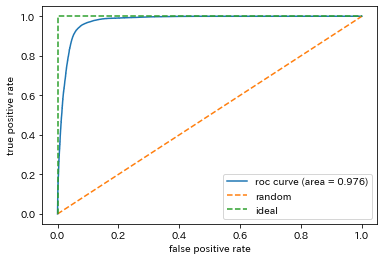

In [9]:
y_score = model.predict_proba(X_test_std)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score, pos_label="successful")

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [10]:
print('auc = ', roc_auc_score(y_true=y_test, y_score=y_score))

auc =  0.9762176517186673
